In [65]:
from easygui import fileopenbox
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import contextily as ctx
import plotly.graph_objects as go
import folium

plt.rcParams['font.family'] = 'Gulim'

In [21]:
data_file = "/content/drive/MyDrive/Colab Notebooks/data/타슈/대전광역시_공영자전거(타슈) 위치(위경도) 현황_20200801.csv"
tashu_station = pd.read_csv(data_file, encoding = 'cp949')

In [22]:
## DataFrame -> GeoDataFrame
gdf_station = gpd.GeoDataFrame(
    tashu_station, crs = 'epsg:4326',
    geometry = gpd.points_from_xy(
        tashu_station.Longitude,
        tashu_station.Latitude
    )
)

gdf_station.head(1)

,연번,Station 스테이션/성명,위치,Latitude,Longitude,광역시도코드,광역시도명,시군구코드,시군구명,법정동코드,법정동명,행정동코드,행정동명,거치대,geometry
0,1,무역전시관입구(택시승강장),대전광역시 유성구 도룡동 3-8,36.374708,127.389027,30,대전광역시,30200,유성구,3020012700,도룡동,3020055000,신성동,14,POINT (127.38903 36.37471)


- 점의 위치, 크기, 색상
    - 위도(Latitude)와 경도(Longtitude) 이용하여 각 자료 점으로 표시
    - 연속형 : 점의 크기
    - 범주형 : 점의 색상

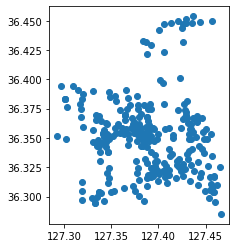

In [23]:
## 위치 표시 - 점
ax = gdf_station.plot()

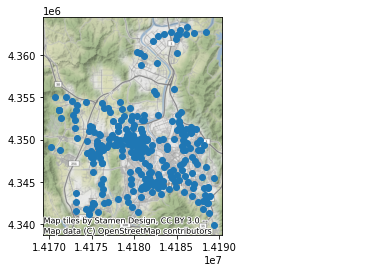

In [24]:
## 위치 표시 - 점 + 지도
ax = gdf_station.to_crs(epsg = 3857).plot()
ctx.add_basemap(ax)

In [25]:
## 시군구명 색상 설정
col_levels = {'유성구':'r', '서구':'g', '대덕구':'b', '중구':'y', '동구':'b'}
gdf_station['color'] = [col_levels[i] for i in gdf_station['시군구명']]

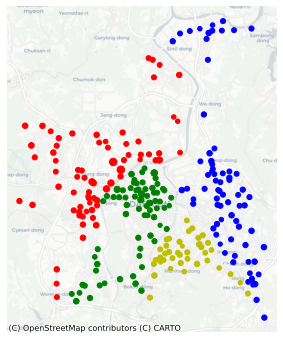

In [29]:
## 위치 표시 - 점 + 지도 + 크기 + 색상
ax = gdf_station.to_crs(epsg = 3857).plot(
    markersize = gdf_station['거치대']*2,
    color = gdf_station['color'],
    figsize = (6, 6))

ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron)
# ax.set_title('대전광역시 타슈 대여소')
ax.set_axis_off()

- 다각형의 위치와 색상
    - 시도 또는 시군구, 읍면동에 대한 다각형 좌표를 이용하여 지도위에 표시
        - 다각형의 좌표를 지정하는 파일 : shp, geojson, csv
    - 연속형 혹은 범주형 변수를 이용하여 다각형 색상 표시

In [30]:
## 시군구 shape file
shp_file = '/content/drive/MyDrive/Colab Notebooks/data/SIG_202101/TL_SCCO_SIG.shp'
sig = gpd.read_file(shp_file, encoding = 'cp949')
sig.head()

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,42110,Chuncheon-si,춘천시,"POLYGON ((1007462.095 2008948.792, 1007512.150..."
1,42130,Wonju-si,원주시,"POLYGON ((1038519.196 1944888.174, 1038552.691..."
2,42150,Gangneung-si,강릉시,"MULTIPOLYGON (((1136545.803 1962251.161, 11365..."
3,42170,Donghae-si,동해시,"MULTIPOLYGON (((1140184.975 1956251.627, 11401..."
4,42190,Taebaek-si,태백시,"POLYGON ((1133987.168 1927444.971, 1133980.895..."


In [32]:
## 대전광역시 추출
cnd = sig['SIG_CD'].str.slice(0, 2) == '30'
sig_30 = sig[cnd]
sig_30

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
119,30110,Dong-gu,동구,"POLYGON ((999321.491 1826867.967, 999239.953 1..."
120,30140,Jung-gu,중구,"POLYGON ((995945.175 1811588.887, 995945.178 1..."
121,30170,Seo-gu,서구,"POLYGON ((988338.682 1810216.004, 988338.685 1..."
122,30200,Yuseong-gu,유성구,"POLYGON ((986874.610 1814985.122, 986851.599 1..."
123,30230,Daedeok-gu,대덕구,"POLYGON ((998333.118 1831051.084, 998569.440 1..."


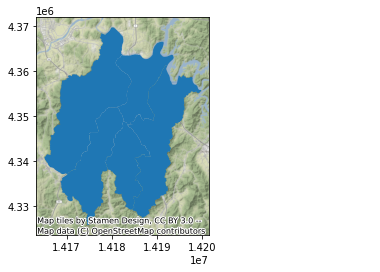

In [33]:
## 다각형 표시
ax = sig_30.to_crs(epsg = 3857).plot()
ctx.add_basemap(ax)

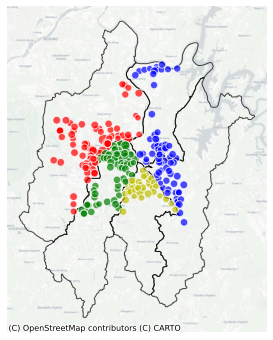

In [38]:
## 위치 표시 - 점 + 지도 + 크기 + 색상 + 다각형
ax = sig_30.to_crs(epsg = 3857).plot(
    color = 'None', edgecolor = 'black', alpha = .7,
    figsize = (6, 6))

gdf_station.to_crs(epsg = 3857).plot(
    markersize = gdf_station['거치대']*4,
    color = gdf_station['color'], edgecolor = 'w', alpha = .7,
    figsize = (6, 6), ax = ax)

ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron)
# ax.set_title('대전광역시 타슈 대여소')
ax.set_axis_off()

In [39]:
## 시군구별 거치대 합
tb = tashu_station.groupby(['시군구명'], as_index = False)['거치대'].sum()

In [40]:
## 자료 병합
sig_30_tb = sig_30.merge(tb, left_on = 'SIG_KOR_NM', right_on = '시군구명')

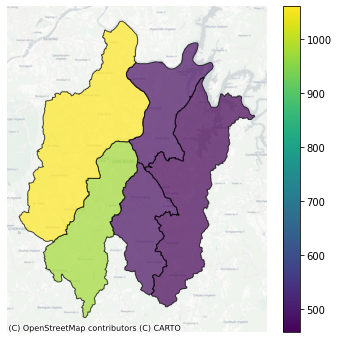

In [42]:
ax = sig_30_tb.to_crs(epsg = 3857).plot(
    column = '거치대',
    legend = True,
    alpha = .7,
    edgecolor = 'k',
    figsize = (6, 6))

ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron)
# ax.set_title('대전광역시 타슈 대여소')
ax.set_axis_off()

##### Plotly

In [48]:
fig = px.scatter_mapbox(gdf_station, lat = 'Latitude', lon = 'Longitude',
                        hover_name = 'Station 스테이션/성명',
                        mapbox_style = 'open-street-map',
                        center = dict(lat = 36.36, lon = 127.38),
                        zoom = 10)
fig.show()

In [50]:
## 위치 표시 - 점 + 지도 + 크기 + 색상
fig = px.scatter_mapbox(gdf_station, lat = 'Latitude', lon = 'Longitude',
                        hover_name = 'Station 스테이션/성명',
                        size = '거치대',
                        color = '시군구명',
                        mapbox_style = 'carto-positron',
                        center = dict(lat = 36.36, lon = 127.38),
                        zoom = 10)
fig.show()

- 밀도(분포) - Mapbox Density Heatmap
    - 연속형 변수의 값을 이용하여 밀도를 나타냄

In [52]:
## Mapbox Density Heatmap
fig = px.density_mapbox(gdf_station, lat = 'Latitude', lon = 'Longitude',
                        z = '거치대',
                        hover_name = 'Station 스테이션/성명',
                        mapbox_style = 'open-street-map',
                        opacity = .8,
                        radius = 20,
                        center = dict(lat = 36.36, lon = 127.38),
                        zoom = 10)
fig.show()

- 다각형의 위치와 색상

In [54]:
## Using GeoPandas Data Frame
df = px.data.election()
geo_df = gpd.GeoDataFrame.from_features(
    px.data.election_geojson()['features']
).merge(df, on = 'district').set_index('district')

fig = px.choropleth_mapbox(geo_df,
                           geojson = geo_df.geometry,
                           locations = geo_df.index,
                           color = 'Joly',
                           center = {'lat':45.5517, 'lon':-73.7073},
                           mapbox_style = 'open-street-map',
                           zoom = 8.5)
fig.show()

- 연결망
    - 점과 선을 이용하여 지역간의 이동량을 표시

In [56]:
data_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/타슈/타슈_연결망.csv', encoding = 'cp949')

data_path['count'].describe()

count     520.000000
mean       89.234615
std        68.326139
min        50.000000
25%        58.750000
50%        72.500000
75%        98.000000
max      1077.000000
Name: count, dtype: float64

In [63]:
## Lines on Maps
fig = go.Figure()

fig = fig.add_trace(
    go.Scattermapbox(
        mode = 'markers',
        text = tashu_station['Station 스테이션/성명'],
        hoverinfo = 'text',
        lon = tashu_station['Longitude'],
        lat = tashu_station['Latitude'],
        marker = {'size':tashu_station['거치대']}))

## 연결망
for i in range(len(data_path)) :
    # 연결 강도
    weight = data_path['count'][i] / data_path['count'].max()
    fig.add_trace(
        go.Scattermapbox(
            lon = [data_path['경도_대여'][i], data_path['경도_반납'][i]],
            lat = [data_path['위도_대여'][i], data_path['위도_반납'][i]],
            mode = 'lines',
            line = dict(width = 2, color = 'red'),
            opacity = weight))
    
  
## 지도 설정
fig.update_layout(
      showlegend = False,
      margin = {'r':0, 't':0, 'l':0, 'b':0},
      mapbox = {
          'center' : {'lat' : 36.36, 'lon' : 127.38},
          'style' : 'carto-positron',
          'zoom' : 11
      }
  )

fig.show()

##### Folium

- 기본 지도

In [66]:
m = folium.Map(location = [36.3352, 127.3976], zoom_start = 12)
m

- 위도와 경도 확인
  - 지도에서 특정 위치를 클릭하면 경도와 위도 표출

In [67]:
m = folium.Map(location = [36.3352, 127.3976], zoom_start = 12)
m.add_child(folium.LatLngPopup())
m

- 지도 저장

In [68]:
m.save('LatLngPopup.html')

- 점의 위치

In [71]:
# base map
m = folium.Map(location = [36.3352, 127.3976], zoom_start = 12)

# add marker one by one on the map
for i in range(len(tashu_station)) :
  folium.Marker(
      location = [tashu_station.iloc[i]['Latitude'],
                  tashu_station.iloc[i]['Longitude']],
                popup = tashu_station.iloc[i]['Station 스테이션/성명'],
  ).add_to(m)
m

- 다각형의 위치와 색상

In [73]:
## base map
m = folium.Map(location = [36.36, 127.39], zoom_start = 10,
               tiles = 'cartodbpositron')

## add layer
folium.Choropleth(
    geo_data = sig_30_tb,
    name = '타슈 대여소',
    data = sig_30_tb,
    columns = ['SIG_KOR_NM', '거치대'],
    key_on = 'feature.properties.SIG_KOR_NM',
    fill_color = 'YlGnBu'
).add_to(m)

## add layer contral
folium.LayerControl().add_to(m)

m